In [1]:
## IMPORT LIBRARIES

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from scipy.io import loadmat
import statsmodels.formula.api as smf

from sklearn.model_selection import GridSearchCV, GroupKFold, PredefinedSplit, ParameterGrid
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
import re

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import linprog
from scipy.sparse import kron, eye, vstack, csr_matrix

In [55]:
# Print versions

import pandas as pd
import numpy as np
import xgboost as xgb
import statsmodels  # Ensure this import is included
import sklearn
import scipy
import matplotlib
import seaborn

import sys
print(sys.version)

# Print versions
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("xgboost version:", xgb.__version__)
print("statsmodels version:", statsmodels.__version__)  # Now this should work
print("scikit-learn version:", sklearn.__version__)
print("scipy version:", scipy.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", seaborn.__version__)

3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
pandas version: 1.4.4
numpy version: 1.21.5
xgboost version: 1.7.6
statsmodels version: 0.14.0
scikit-learn version: 1.0.2
scipy version: 1.9.1
matplotlib version: 3.5.2
seaborn version: 0.11.2


In [2]:
## LOAD THE DATA, CLEAN, AND SET THE CROSS-VALIDATION / PREDICTION DATASET

# Load data
data = pd.read_csv('data.csv', index_col=0)

# Set distance to 0 if the exporter origin is the same as the importer destionation
data.loc[data['iso_d'] == data['iso_o'], 'dist'] = 0


# Find indices where 'trade_value' is not NaN and 'total_export_value' is greater than 10^7
z_vals = data[(~data['trade_value'].isna()) & (data['total_export_value'] > 10**7)].index


# Apply log transformation
data_log = data.copy()
log_transform_columns = ['trade_value', 'total_export_value', 'total_category_value',
                         'iso_o_gdp', 'iso_d_gdp', 'dist',
                         'iso_o_internet', 'iso_d_internet', 'iso_o_fixed_broadband', 
                         'iso_d_fixed_broadband', 'iso_o_mobile_broadband', 'iso_d_mobile_broadband',
                         'revenues_iso_o']

for col in log_transform_columns:
    data_log[col] = np.log(1 + data_log[col])


# Apply categorical transformation
categorical_cols = ['year', 'category', 'iso_o_loc', 'iso_d_loc']
for col in categorical_cols:
    data_log[col] = data_log[col].astype('category')  

# Get the data used for regression
data_regression = data_log.loc[z_vals]

In [57]:
data_v2 = data.copy()
data_v2['trade_value'] = np.nan
data_v2['total_export_value'] = np.nan
data_v2.to_csv('data_cleaned.csv')

In [4]:
## REGRESSION TREE CROSS-VALIDATION


# One hot encoding of categorical variables
X = data_regression.copy()

for col in ['iso_o_loc', 'iso_d_loc', 'year']:  # list all your categorical columns
    dummies = pd.get_dummies(data_regression[col], prefix=col, drop_first=False)
    X = pd.concat([X, dummies], axis=1).drop(col, axis=1)

y = data_regression['trade_value']  
X.drop(['category', 'firm', 'iso_o', 'iso_d', 'trade_value'], axis=1, inplace=True)

# Set baseline categories for logistic regression
X_log_reg = X.copy()
X_log_reg.drop(['iso_o_loc_North America', 'iso_d_loc_North America', 'year_2016'], axis=1, inplace=True)

# Create the group variable
groups = data_regression['firm'].astype(str) + '_' + data_regression['iso_o'].astype(str) + '_' + data_regression['category'].astype(str)
groups = groups.astype(str).factorize()[0]

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Parameter grid for GridSearchCV
param_grid = {'max_depth': [1, 3, 5, 7], 
              'min_child_weight': [5, 20, 50, 100, 200]}

# For storing the results
mse_scores_per_set = {tuple(sorted(param.items())): [] for param in ParameterGrid(param_grid)}
mse_train_scores_per_set = {tuple(sorted(param.items())): [] for param in ParameterGrid(param_grid)}

# Iterate over each fold
fold_num = 0
for train_index, test_index in gkf.split(X, y, groups=groups):
    fold_num += 1
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    X_log_reg_train, X_log_reg_test = X_log_reg.iloc[train_index].copy(), X_log_reg.iloc[test_index].copy()
    
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

    # Fit logistic regression for zeroProbabilities
    log_reg = LogisticRegression(max_iter=2000)
    log_reg.fit(X_log_reg_train, (y_train > 0))
    X_train['zeroProbabilities'] = log_reg.predict_proba(X_log_reg_train)[:, 1]
    X_test['zeroProbabilities'] = log_reg.predict_proba(X_log_reg_test)[:, 1]

    # Manually iterate over each combination of hyperparameters
    for params in ParameterGrid(param_grid):
        
        estimator = XGBRegressor(**params, n_estimators=150, learning_rate=0.10,
                                  random_state=42)
        estimator.fit(X_train, y_train)
        
        y_pred = estimator.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        y_fit = estimator.predict(X_train)
        mse_train = mean_squared_error(y_train, y_fit)
        
        # Print fold number, parameters, and MSE
        print(f"Fold {fold_num}, Params: {params}, MSE: {mse}, MSEtrain: {mse_train}")
        
        mse_scores_per_set[tuple(sorted(params.items()))].append(mse)
        mse_train_scores_per_set[tuple(sorted(params.items()))].append(mse_train)


# Calculate average MSE for each parameter set
avg_mse_scores = {params: np.mean(mse_scores) for params, mse_scores in mse_scores_per_set.items()}
avg_mse_train_scores = {params: np.mean(mse_train_scores) for params, mse_train_scores in mse_train_scores_per_set.items()}

# Determine the best parameter set
best_params = min(avg_mse_scores, key=avg_mse_scores.get)
best_score = avg_mse_scores[best_params]
best_train_score = avg_mse_train_scores[best_params]

print("Best parameters based on average MSE across folds:", dict(best_params))
print("Best average MSE:", best_score)
print("Best train average MSE:", best_train_score)

Fold 1, Params: {'max_depth': 1, 'min_child_weight': 5}, MSE: 23.4581288453166, MSEtrain: 23.071110677781693
Fold 1, Params: {'max_depth': 1, 'min_child_weight': 20}, MSE: 23.4581288453166, MSEtrain: 23.071110677781693
Fold 1, Params: {'max_depth': 1, 'min_child_weight': 50}, MSE: 23.4581288453166, MSEtrain: 23.071110677781693
Fold 1, Params: {'max_depth': 1, 'min_child_weight': 100}, MSE: 23.4581288453166, MSEtrain: 23.071110677781693
Fold 1, Params: {'max_depth': 1, 'min_child_weight': 200}, MSE: 23.4581288453166, MSEtrain: 23.071110677781693
Fold 1, Params: {'max_depth': 3, 'min_child_weight': 5}, MSE: 23.667246266237164, MSEtrain: 20.43554055793297
Fold 1, Params: {'max_depth': 3, 'min_child_weight': 20}, MSE: 23.680149059534, MSEtrain: 20.40995169283984
Fold 1, Params: {'max_depth': 3, 'min_child_weight': 50}, MSE: 23.76262429935147, MSEtrain: 20.500908538990334
Fold 1, Params: {'max_depth': 3, 'min_child_weight': 100}, MSE: 23.75505090605177, MSEtrain: 20.497204746112807
Fold 1, 

Fold 4, Params: {'max_depth': 5, 'min_child_weight': 200}, MSE: 23.803416238454396, MSEtrain: 18.10314290841455
Fold 4, Params: {'max_depth': 7, 'min_child_weight': 5}, MSE: 24.192482380375306, MSEtrain: 13.958882858592158
Fold 4, Params: {'max_depth': 7, 'min_child_weight': 20}, MSE: 23.984069782679697, MSEtrain: 14.15198829355762
Fold 4, Params: {'max_depth': 7, 'min_child_weight': 50}, MSE: 24.27950734995689, MSEtrain: 14.445997173145114
Fold 4, Params: {'max_depth': 7, 'min_child_weight': 100}, MSE: 24.115993749175246, MSEtrain: 15.390458246260678
Fold 4, Params: {'max_depth': 7, 'min_child_weight': 200}, MSE: 24.177812078911153, MSEtrain: 15.858599902106304
Fold 5, Params: {'max_depth': 1, 'min_child_weight': 5}, MSE: 24.390838550476598, MSEtrain: 22.83163891470625
Fold 5, Params: {'max_depth': 1, 'min_child_weight': 20}, MSE: 24.390838550476598, MSEtrain: 22.83163891470625
Fold 5, Params: {'max_depth': 1, 'min_child_weight': 50}, MSE: 24.390838550476598, MSEtrain: 22.831638914706

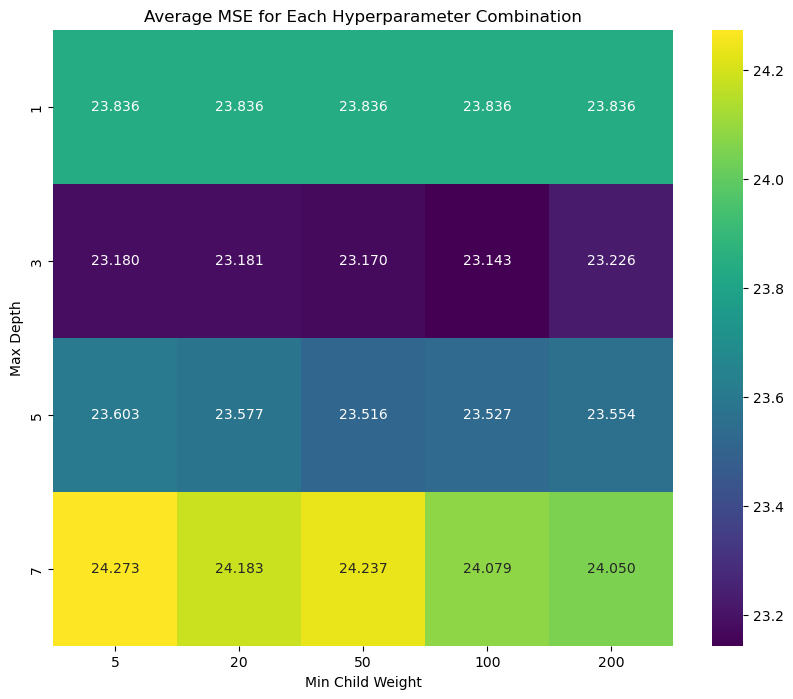

In [5]:
## PLOT CROSS-VALIDATION HEATMAP

# Assume avg_mse_scores is available in your environment

# Convert to DataFrame and pivot
avg_mse_df = pd.DataFrame.from_dict(avg_mse_scores, orient='index', columns=['avg_mse'])
avg_mse_df['max_depth'] = avg_mse_df.index.map(lambda x: dict(x)['max_depth'])
avg_mse_df['min_child_weight'] = avg_mse_df.index.map(lambda x: dict(x)['min_child_weight'])
avg_mse_pivot = avg_mse_df.pivot('max_depth', 'min_child_weight', 'avg_mse')

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(avg_mse_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Average MSE for Each Hyperparameter Combination")
plt.xlabel("Min Child Weight")
plt.ylabel("Max Depth")
plt.show()

In [12]:
## COMPARE WITH LINEAR REGRESSION


# One hot encoding of categorical variables
X = data_regression.copy()

for col in ['iso_o_loc', 'iso_d_loc', 'year']:  # list all your categorical columns
    dummies = pd.get_dummies(data_regression[col], prefix=col, drop_first=False)
    X = pd.concat([X, dummies], axis=1).drop(col, axis=1)
    
y = data_regression['trade_value']  
X.drop(['category', 'firm', 'iso_o', 'iso_d', 'trade_value'], axis=1, inplace=True)

# Remove baseline categories
X.drop(['iso_o_loc_North America', 'iso_d_loc_North America', 'year_2016'], axis=1, inplace=True)

# For storing MSE values
mse_scores_lin_reg = []

# Iterate over each fold
fold_num = 0
for train_index, test_index in gkf.split(X, y, groups=groups):
    fold_num += 1
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

    # Fit the linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Predict on the test set and calculate MSE
    y_pred = lin_reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    
    # Store and print MSE
    mse_scores_lin_reg.append(mse)

    print(f"Fold {fold_num}, MSE: {mse}")

# Calculate the average MSE across all folds
avg_mse_lin_reg = np.mean(mse_scores_lin_reg)
print(f"Average MSE for Linear Regression: {avg_mse_lin_reg}")


Fold 1, MSE: 24.142554196242493
Fold 2, MSE: 22.41691635231316
Fold 3, MSE: 25.808471406909888
Fold 4, MSE: 24.833735302166357
Fold 5, MSE: 25.01904015585496
Average MSE for Linear Regression: 24.44414348269737


In [16]:
## GET FINAL PREDICTIONS


X = data_regression.copy()

for col in ['iso_o_loc', 'iso_d_loc', 'year']:  # list all your categorical columns
    dummies = pd.get_dummies(data_regression[col], prefix=col, drop_first=False)
    X = pd.concat([X, dummies], axis=1).drop(col, axis=1)

y = data_regression['trade_value']  
X.drop(['category', 'firm', 'iso_o', 'iso_d', 'trade_value'], axis=1, inplace=True)

X_log_reg = X.copy()
X_log_reg.drop(['iso_o_loc_North America', 'iso_d_loc_North America', 'year_2016'], axis=1, inplace=True)


# Fit logistic regression for zeroProbabilities on all data
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_log_reg, (y > 0))
zero_prob = log_reg.predict_proba(X_log_reg)[:, 1]

# Add zeroProbabilities to the feature set
X['zeroProbabilities'] = zero_prob

X_prediction = data_log.copy()

for col in ['iso_o_loc', 'iso_d_loc', 'year']:  # list all your categorical columns
    dummies = pd.get_dummies(data_log[col], prefix=col, drop_first=False)
    X_prediction = pd.concat([X_prediction, dummies], axis=1).drop(col, axis=1)

X_prediction.drop(['category', 'firm', 'iso_o', 'iso_d', 'trade_value'], axis=1, inplace=True)

X_prediction_log_reg = X_prediction.copy()
X_prediction_log_reg.drop(['iso_o_loc_North America', 'iso_d_loc_North America', 'year_2016'], axis=1, inplace=True)


# Fit logistic regression for zeroProbabilities on all data
zero_prob = log_reg.predict_proba(X_prediction_log_reg)[:, 1]

# Add zeroProbabilities to the feature set
X_prediction['zeroProbabilities'] = zero_prob

# Fit the GBRT
gbr = XGBRegressor(learning_rate=0.1, n_estimators=150,
                       max_depth=best_params[0][1],
                       min_child_weight=best_params[1][1],
                       random_state=42)
gbr.fit(X, y)


# Fit the linear regression model
lin_reg.fit(X_log_reg, y)




data['ypred_combined'] = gbr.predict(X_prediction)
data['ypred_linear_combined'] = lin_reg.predict(X_prediction_log_reg)


columns_to_keep = ['firm', 'year', 'category', 'iso_o', 'iso_d', 'trade_value', 'total_export_value', 'ypred_combined', 'ypred_linear_combined']

# Select only these columns
TT_reduced = data[columns_to_keep].copy()

# Create non-normalized predictions
TT_reduced['trade_value_pred'] = np.exp(TT_reduced['ypred_combined']) - 1
TT_reduced.loc[TT_reduced['trade_value_pred'] < 1000, 'trade_value_pred'] = 0

TT_reduced['trade_value_linear_pred'] = np.exp(TT_reduced['ypred_linear_combined']) - 1
TT_reduced.loc[TT_reduced['trade_value_linear_pred'] < 1000, 'trade_value_linear_pred'] = 0


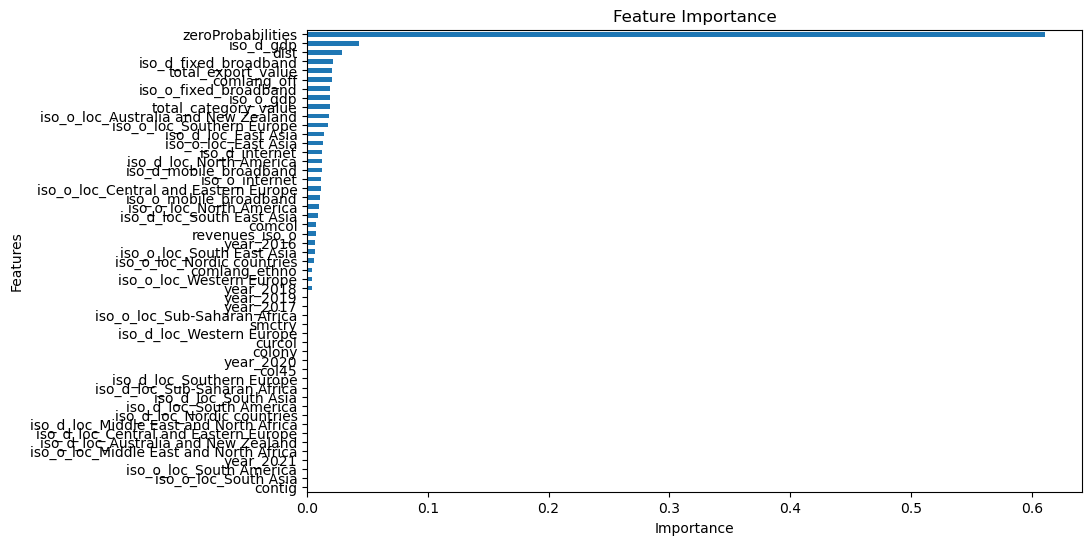

In [35]:
## PLOT FEATURE IMPORTANCE

# Get feature importances
#feature_importances = best_model.get_booster().get_score(importance_type='gain')
feature_importances = gbr.feature_importances_

# Get feature names
feature_names = X.columns

# Create a pandas series for easy plotting
importances_series = pd.Series(feature_importances, index=feature_names)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importances_series.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [19]:
## POST PROCESSING # 1 - summing up to firm revenues

# Calculate normalized values for categories other than 'apps' and 'games'
non_app_game_mask = ~TT_reduced['category'].isin(['apps', 'games'])
grouped = TT_reduced[non_app_game_mask].groupby(['firm', 'year', 'category', 'iso_o'])
TT_reduced.loc[non_app_game_mask, 'normalized_trade_value_pred'] = grouped['trade_value_pred'].transform(lambda x: x / x.sum() * TT_reduced.loc[x.index, 'total_export_value'])
TT_reduced.loc[non_app_game_mask, 'normalized_trade_value_linear_pred'] = grouped['trade_value_linear_pred'].transform(lambda x: x / x.sum() * TT_reduced.loc[x.index, 'total_export_value'])

# For 'apps' and 'games' categories, set normalized_trade_value_pred based on the condition
app_game_mask = TT_reduced['category'].isin(['apps', 'games'])
TT_reduced.loc[app_game_mask, 'normalized_trade_value_pred'] = TT_reduced.loc[app_game_mask, 'trade_value'].fillna(TT_reduced.loc[app_game_mask, 'trade_value_pred'])
TT_reduced.loc[app_game_mask, 'normalized_trade_value_linear_pred'] = TT_reduced.loc[app_game_mask, 'trade_value'].fillna(TT_reduced.loc[app_game_mask, 'trade_value_linear_pred'])

## POST-PROCESSING #2 - sum up to regional revenues

# load firm revenue shares
firm_revenue_shares = pd.read_excel('firm-revenue-share.xlsx', sheet_name='shares')
firm_revenue_regions = pd.read_excel('firm-revenue-share.xlsx', sheet_name='regions')

# Calculate the total revenue for each firm-category-year group
total_revenue = TT_reduced.groupby(['firm','iso_o', 'category', 'year'])['normalized_trade_value_pred'].sum().reset_index(name='total_revenue')
total_not_revenue = TT_reduced.groupby(['firm','iso_o', 'category', 'year'])['trade_value_pred'].sum().reset_index(name='total_not_revenue')


# Step 1. calculate revenue share for apps and games

# Step 1.1: Merge this total revenue back into TT_reduced
TT_reduced = TT_reduced.merge(total_revenue, on=['firm', 'iso_o', 'category', 'year'])
TT_reduced = TT_reduced.merge(total_not_revenue, on=['firm', 'iso_o', 'category', 'year'])
app_game_mask = TT_reduced['category'].isin(['apps', 'games'])

# Step 1.2: Use the mask with .loc to update 'total_not_revenue' where the condition is True
TT_reduced.loc[app_game_mask, 'total_not_revenue'] = TT_reduced.loc[app_game_mask, 'total_revenue'].astype('float32')

# Step 1.3: Calculate the revenue_share
TT_reduced['revenue_share'] = TT_reduced['trade_value_pred'] / TT_reduced['total_not_revenue']
TT_reduced.loc[app_game_mask, 'revenue_share'] = (TT_reduced.loc[app_game_mask, 'normalized_trade_value_pred'] / TT_reduced.loc[app_game_mask, 'total_revenue']).astype('float32')



# Step 2: Adjust for countries with known consumption

# Step 2.1: Merge TT_reduced with firm_revenue_shares
TT_reduced = pd.merge(TT_reduced, firm_revenue_shares, how='left', left_on=['firm', 'iso_d'], right_on=['firm', 'region_iso_d'], suffixes=('', '_frs'))

# Step 2.2: Compute the final_revenue_share
TT_reduced['final_revenue_share'] = TT_reduced['revenue_share_frs'].where(pd.notnull(TT_reduced['revenue_share_frs']), None)

# Drop the extra columns introduced by the merge
TT_reduced.drop(['region_iso_d', 'revenue_share_frs'], axis=1, inplace=True)


# Step 3. Adjust for regions with known consumption

# Step 3.1: Pre-compute the mapping from regions to countries
region_to_countries = {region: firm_revenue_regions[region].dropna().unique().tolist()
                       for region in firm_revenue_regions.columns}

# Step 3.2: Identify rows in firm_revenue_shares not included in the first step
unprocessed_frs = firm_revenue_shares[~firm_revenue_shares['region_iso_d'].isin(TT_reduced['iso_d'].unique())]


# Calculate the total number of iterations for progress tracking
total_iterations = len(unprocessed_frs)

# Step 3.3: Iterate over unprocessed firm_revenue_shares and renormalize revenue shares
for i, (index, frs_row) in enumerate(unprocessed_frs.iterrows(), 1):
    firm = frs_row['firm']
    region_iso_d = frs_row['region_iso_d']
    target_revenue_share = frs_row['revenue_share']

    if region_iso_d in region_to_countries:
        region_vals = region_to_countries[region_iso_d]

        # Filter TT_reduced for the current firm and get unique categories
        firm_categories = TT_reduced[TT_reduced['firm'] == firm]['category'].unique()

        for year in TT_reduced['year'].unique():
            for category in firm_categories:
                mask = (TT_reduced['firm'] == firm) & (TT_reduced['year'] == year) & \
                       (TT_reduced['category'] == category) & (TT_reduced['iso_d'].isin(region_vals))

                relevant_rows = TT_reduced[mask]
                total_share = relevant_rows['revenue_share'].sum()

                if total_share > 0:
                    scaling_factor = target_revenue_share / total_share
                    TT_reduced.loc[mask, 'final_revenue_share'] = relevant_rows['revenue_share'] * scaling_factor

    # Display the percentage completed
    percentage_completed = (i / total_iterations) * 100
    print(f"Completed: {percentage_completed:.2f}%")

# Step 4: Normalize the values for each region/country and product with unknown regional data

# Step 4.1: Identify firms in TT_reduced not present in firm_revenue_shares
unique_firms_in_frs = firm_revenue_shares['firm'].unique()
firms_not_in_frs = TT_reduced.loc[~TT_reduced['firm'].isin(unique_firms_in_frs), 'firm'].unique()

# Step 4.2: 
# Set final_revenue_share equal to revenue_share for these firms
TT_reduced.loc[TT_reduced['firm'].isin(firms_not_in_frs), 'final_revenue_share'] = TT_reduced['revenue_share']

# Group by 'firm', 'category', 'year' and calculate the sum of 'final_revenue_share' 
# Step 4.3: Identify groups with at least one NaN in final_revenue_share
groups_with_nan = TT_reduced[TT_reduced['final_revenue_share'].isna()].groupby(['firm', 'iso_o', 'category', 'year']).size().reset_index(name='count').drop(columns='count')

# Step 4.4: Calculate the sum of final_revenue_share for each group, excluding NaN values
grouped_sum = TT_reduced.groupby(['firm', 'iso_o', 'category', 'year'])['final_revenue_share'].sum(min_count=1).reset_index()

# Step 4.5: Merge to include only groups identified in step 4.4
grouped_sum = groups_with_nan.merge(grouped_sum, on=['firm', 'iso_o', 'category', 'year'], how='left')

# Merge this back to TT_reduced only for rows where 'final_revenue_share' is NaN
TT_reduced = TT_reduced.merge(grouped_sum, on=['firm', 'iso_o', 'category', 'year'], how='left', suffixes=('', '_group_sum'))

# Calculate the total number of iterations for progress tracking
total_iterations = len(grouped_sum)

# Iterate over each group and normalize NaN entries in 'final_revenue_share'
for i, row in enumerate(grouped_sum.iterrows(), 1):
    firm = row[1]['firm']
    category = row[1]['category']
    year = row[1]['year']
    group_sum = row[1]['final_revenue_share']

    mask = (TT_reduced['firm'] == firm) & (TT_reduced['category'] == category) & (TT_reduced['year'] == year) & TT_reduced['final_revenue_share'].isna()
    
    # Calculate the sum of 'revenue_share' for NaN entries
    nan_sum = TT_reduced.loc[mask, 'revenue_share'].sum()

    # Normalize NaN entries
    if nan_sum > 0:
        normalization_factor = (1 - group_sum) / nan_sum
        TT_reduced.loc[mask, 'final_revenue_share'] = TT_reduced.loc[mask, 'revenue_share'] * normalization_factor

    # Display the percentage completed
    percentage_completed = (i / total_iterations) * 100
    print(f"Completed: {percentage_completed:.2f}%")

# Drop the extra '_group_sum' column
TT_reduced.drop('final_revenue_share_group_sum', axis=1, inplace=True)

TT_reduced['final_revenue_share'] = TT_reduced['final_revenue_share'].apply(lambda x: 0 if x < 10**-8 else x)

estimated_rev_share = TT_reduced.groupby(['firm','iso_o', 'category', 'year'])['final_revenue_share'].sum().reset_index(name='estimated_rev_share')
TT_reduced = TT_reduced.merge(estimated_rev_share, on=['firm', 'iso_o', 'category', 'year'])
TT_reduced['final_revenue_share'] = TT_reduced['final_revenue_share'] / TT_reduced['estimated_rev_share']
TT_reduced['normalized_trade_value_pred'] = TT_reduced['final_revenue_share'] * TT_reduced['total_revenue']
TT_reduced['year'] = TT_reduced['year'].astype(int)

Completed: 1.22%
Completed: 2.44%
Completed: 3.66%
Completed: 4.88%
Completed: 6.10%
Completed: 7.32%
Completed: 8.54%
Completed: 9.76%
Completed: 10.98%
Completed: 12.20%
Completed: 13.41%
Completed: 14.63%
Completed: 15.85%
Completed: 17.07%
Completed: 18.29%
Completed: 19.51%
Completed: 20.73%
Completed: 21.95%
Completed: 23.17%
Completed: 24.39%
Completed: 25.61%
Completed: 26.83%
Completed: 28.05%
Completed: 29.27%
Completed: 30.49%
Completed: 31.71%
Completed: 32.93%
Completed: 34.15%
Completed: 35.37%
Completed: 36.59%
Completed: 37.80%
Completed: 39.02%
Completed: 40.24%
Completed: 41.46%
Completed: 42.68%
Completed: 43.90%
Completed: 45.12%
Completed: 46.34%
Completed: 47.56%
Completed: 48.78%
Completed: 50.00%
Completed: 51.22%
Completed: 52.44%
Completed: 53.66%
Completed: 54.88%
Completed: 56.10%
Completed: 57.32%
Completed: 58.54%
Completed: 59.76%
Completed: 60.98%
Completed: 62.20%
Completed: 63.41%
Completed: 64.63%
Completed: 65.85%
Completed: 67.07%
Completed: 68.29%


Completed: 70.13%
Completed: 70.32%
Completed: 70.50%
Completed: 70.69%
Completed: 70.87%
Completed: 71.06%
Completed: 71.24%
Completed: 71.43%
Completed: 71.61%
Completed: 71.80%
Completed: 71.99%
Completed: 72.17%
Completed: 72.36%
Completed: 72.54%
Completed: 72.73%
Completed: 72.91%
Completed: 73.10%
Completed: 73.28%
Completed: 73.47%
Completed: 73.65%
Completed: 73.84%
Completed: 74.03%
Completed: 74.21%
Completed: 74.40%
Completed: 74.58%
Completed: 74.77%
Completed: 74.95%
Completed: 75.14%
Completed: 75.32%
Completed: 75.51%
Completed: 75.70%
Completed: 75.88%
Completed: 76.07%
Completed: 76.25%
Completed: 76.44%
Completed: 76.62%
Completed: 76.81%
Completed: 76.99%
Completed: 77.18%
Completed: 77.37%
Completed: 77.55%
Completed: 77.74%
Completed: 77.92%
Completed: 78.11%
Completed: 78.29%
Completed: 78.48%
Completed: 78.66%
Completed: 78.85%
Completed: 79.04%
Completed: 79.22%
Completed: 79.41%
Completed: 79.59%
Completed: 79.78%
Completed: 79.96%
Completed: 80.15%
Completed:

In [20]:
# Filter the DataFrame for rows where iso_d is not equal to iso_o
non_domestic_data = TT_reduced[(TT_reduced['iso_d'] != TT_reduced['iso_o'])]

summed_by_year = non_domestic_data.groupby('year')['normalized_trade_value_pred'].sum()

print(summed_by_year/10**9)

year
2016    339.395184
2017    414.989382
2018    506.889758
2019    603.819810
2020    708.593476
2021    919.249109
Name: normalized_trade_value_pred, dtype: float64


In [21]:
# Filter the DataFrame for entries of ALPHABET INC. BYTEDANCE INC ALI BABA GROUP LLC
TT_reduced_2 = TT_reduced.sort_values(by='normalized_trade_value_pred', ascending=False)
alphabet_data = TT_reduced_2[(TT_reduced_2['firm'] == 'ALI BABA GROUP LLC') & (TT_reduced['year'] == 2021)]
alphabet_data = alphabet_data.sort_values(by='normalized_trade_value_pred', ascending=False)

# Sum of normalized_trade_value_pred for ALPHABET INC. in USA
alphabet_usa_sum = alphabet_data[(alphabet_data['iso_d'] == 'CHN')]['normalized_trade_value_pred'].sum()
alphabet_usa_linear_sum = alphabet_data[(alphabet_data['iso_d'] == 'CHN')]['normalized_trade_value_linear_pred'].sum()

# Total sum of normalized_trade_value_pred for ALPHABET INC. across all iso_d
total_alphabet_sum = alphabet_data['normalized_trade_value_pred'].sum()
total_alphabet_linear_sum = alphabet_data['normalized_trade_value_linear_pred'].sum()


# Calculate the share
usa_in_alphabet_share = alphabet_usa_sum / total_alphabet_sum
usa_in_alphabet_linear_share = alphabet_usa_linear_sum / total_alphabet_linear_sum


print(f"Share of USA in ALPHABET INC.: {usa_in_alphabet_share}")
print(f"Share of USA in Linear ALPHABET INC.: {usa_in_alphabet_linear_share}")
alphabet_data

/var/folders/sy/p2nr_88j7bn73lhkcg0j43k00000gn/T/ipykernel_84590/1490072190.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alphabet_data = TT_reduced_2[(TT_reduced_2['firm'] == 'ALI BABA GROUP LLC') & (TT_reduced['year'] == 2021)]


Share of USA in ALPHABET INC.: 0.3082054151933
Share of USA in Linear ALPHABET INC.: 0.9751915395725214


,firm,year,category,iso_o,iso_d,trade_value,total_export_value,ypred_combined,ypred_linear_combined,trade_value_pred,trade_value_linear_pred,normalized_trade_value_pred,normalized_trade_value_linear_pred,total_revenue,total_not_revenue,revenue_share,final_revenue_share,estimated_rev_share
4992536,ALI BABA GROUP LLC,2021,online-marketplace,CHN,CHN,NaN,7.331276e+10,20.226978,25.310493,6.087866e+08,9.822165e+10,2.230696e+10,7.149398e+10,7.331276e+10,2.000803e+09,0.304271,0.304271,1.0
4992669,ALI BABA GROUP LLC,2021,online-marketplace,CHN,USA,NaN,7.331276e+10,19.660183,18.683731,3.453894e+08,1.300892e+08,1.265564e+10,9.468983e+07,7.331276e+10,2.000803e+09,0.172625,0.172625,1.0
4992587,ALI BABA GROUP LLC,2021,online-marketplace,CHN,JPN,NaN,7.331276e+10,19.106108,17.370951,1.984619e+08,3.500322e+07,7.271976e+09,2.547828e+07,7.331276e+10,2.000803e+09,0.099191,0.099191,1.0
4992362,ALI BABA GROUP LLC,2021,cloud-computing,CHN,CHN,NaN,1.345687e+10,20.226978,22.442608,6.087866e+08,5.580859e+09,4.435915e+09,1.312303e+10,1.345687e+10,1.846826e+09,0.329639,0.329639,1.0
4992495,ALI BABA GROUP LLC,2021,cloud-computing,CHN,USA,NaN,1.345687e+10,19.660183,15.815847,3.453894e+08,7.391538e+06,2.516675e+09,1.738073e+07,1.345687e+10,1.846826e+09,0.187018,0.187018,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992331,ALI BABA GROUP LLC,2021,cloud-computing,CHN,AGO,NaN,1.345687e+10,11.697001,10.679638,1.202096e+05,4.346083e+04,8.759056e+05,1.021953e+05,1.345687e+10,1.846826e+09,0.000065,0.000065,1.0
4992424,ALI BABA GROUP LLC,2021,cloud-computing,CHN,LBR,NaN,1.345687e+10,11.214479,8.750447,7.419603e+04,6.312508e+03,5.406283e+05,1.484346e+04,1.345687e+10,1.846826e+09,0.000040,0.000040,1.0
4992483,ALI BABA GROUP LLC,2021,cloud-computing,CHN,TCD,NaN,1.345687e+10,11.044659,8.821020,6.260764e+04,6.774172e+03,4.561897e+05,1.592903e+04,1.345687e+10,1.846826e+09,0.000034,0.000034,1.0
4992448,ALI BABA GROUP LLC,2021,cloud-computing,CHN,NER,NaN,1.345687e+10,10.794407,8.964374,4.874639e+04,7.818489e+03,3.551899e+05,1.838467e+04,1.345687e+10,1.846826e+09,0.000026,0.000026,1.0


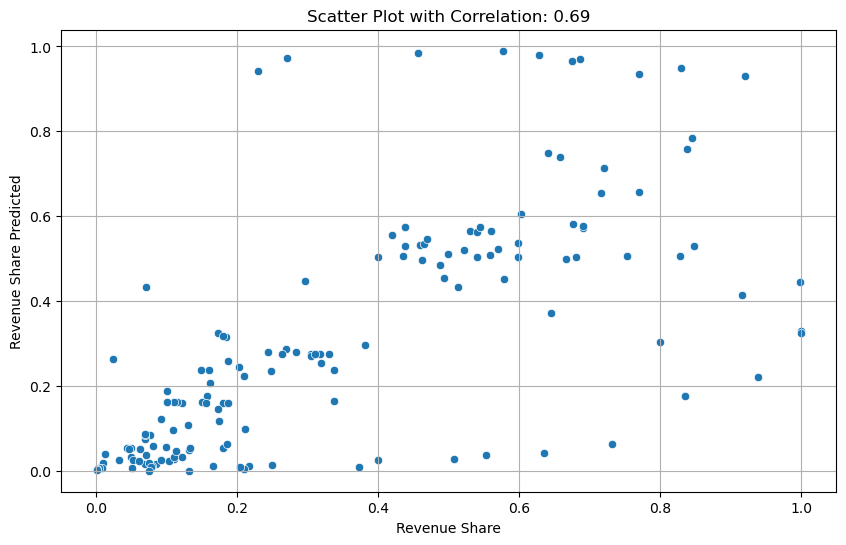

In [36]:
## PLOT REVENUE SHARE

# Assuming TT_reduced_2, firm_revenue_shares, and firm_revenue_regions are already loaded DataFrames
TT_reduced_2 = TT_reduced.copy()
firm_revenue_shares = pd.read_excel('firm-revenue-share.xlsx', sheet_name='shares')

# Filter TT_reduced_2 to include only firms present in firm_revenue_shares
relevant_firms = firm_revenue_shares['firm'].unique()
TT_reduced_2_filtered = TT_reduced_2[TT_reduced_2['firm'].isin(relevant_firms)]

# Filter TT_reduced_2 to include only data for the year 2021
TT_reduced_2021 = TT_reduced_2_filtered[TT_reduced_2_filtered['year'] == 2021]

# Group by 'firm' and sum up 'normalized_trade_value_pred' and 'normalized_trade_value_pred_linear' across all categories
firm_summaries = TT_reduced_2021.groupby(['firm','iso_d'])[['trade_value_pred', 'trade_value_linear_pred','normalized_trade_value_pred']].sum().reset_index()

# Step 1: Calculate Total Revenue per Firm
total_revenue = firm_summaries.groupby('firm')[['trade_value_pred', 'trade_value_linear_pred', 'normalized_trade_value_pred']].sum()

# Step 2: Calculate Revenue Share for Each Region
def calculate_revenue_share(row, summaries, total_revenue, column_name):
    firm = row['firm']
    region_iso_d = row['region_iso_d']
    if region_iso_d in summaries['iso_d'].unique():
        region_sum = summaries[(summaries['firm'] == firm) & (summaries['iso_d'] == region_iso_d)][column_name].sum()
    else:
        # Use the firm_revenue_regions DataFrame
        alternative_regions = firm_revenue_regions[region_iso_d].unique()
        region_sum = summaries[(summaries['firm'] == firm) & (summaries['iso_d'].isin(alternative_regions))][column_name].sum()
    total_firm_revenue = total_revenue.loc[firm, column_name]
    return region_sum / total_firm_revenue if total_firm_revenue != 0 else 0

firm_revenue_shares['revenue_share_predicted'] = firm_revenue_shares.apply(lambda row: calculate_revenue_share(row, firm_summaries, total_revenue, 'trade_value_pred'), axis=1)
firm_revenue_shares['revenue_share_linear'] = firm_revenue_shares.apply(lambda row: calculate_revenue_share(row, firm_summaries, total_revenue, 'trade_value_linear_pred'), axis=1)
firm_revenue_shares['revenue_share_final'] = firm_revenue_shares.apply(lambda row: calculate_revenue_share(row, firm_summaries, total_revenue, 'normalized_trade_value_pred'), axis=1)

# Step 3: The firm_revenue_shares DataFrame now has the new columns 'revenue_share' and 'revenue_share_linear' added

# Creating the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='revenue_share', y='revenue_share_predicted', data=firm_revenue_shares)

# Calculating the correlation
correlation = firm_revenue_shares['revenue_share'].corr(firm_revenue_shares['revenue_share_predicted'])
# Calculating the R-squared value

# Adding the title with the correlation value
plt.title(f'Scatter Plot with Correlation: {correlation:.2f}')
plt.xlabel('Revenue Share')
plt.ylabel('Revenue Share Predicted')
plt.grid(True)
plt.show()

firm_revenue_shares.to_csv('predicted_shares.csv')

In [58]:
## OPTIMAL TRANSPORT

# Load distance data
data_distance = pd.read_excel('dist_data.xlsx')
data_distance = data_distance[['iso_o', 'iso_d', 'dist']]

# Set 'dist' to 1 where 'iso_o' is equal to 'iso_d'
data_distance.loc[data_distance['iso_o'] == data_distance['iso_d'], 'dist'] = 0

# Load firm revenues by subsidiary_data
firm_subsidiary_revenues = pd.read_csv('firm_revenues_by_subsidiary.csv')
    
def dpt_optimal_transport(Q, R, D):
    # Normalize revenues and consumption
    R = 1e4 * R / np.sum(R)
    Q = 1e4 * Q / np.sum(Q)

    # Reshape and normalize Phi_vec
    Phi_vec = D.flatten()
    Phi_vec = Phi_vec

    # Create sparse matrices for constraints
    num_R = len(R)
    num_Q = len(Q)
    Aeq_top = kron(csr_matrix(np.ones((1, num_R))), eye(num_Q))
    Aeq_bottom = kron(eye(num_R), csr_matrix(np.ones((1, num_Q))))
    Aeq = vstack([Aeq_top, Aeq_bottom], format='csr')
    beq = np.concatenate([Q, R])

    # Define bounds, and linear programming
    W0 = np.ones_like(Phi_vec) / len(Phi_vec)
    lb = np.zeros_like(W0)
    ub = 1e4 * np.ones_like(W0)
    res = linprog(-Phi_vec, A_eq=Aeq, b_eq=beq, bounds=list(zip(lb, ub)), method='highs')
    
    if not res.success:
        raise ValueError(f"Linear programming did not succeed: {res.message}")


    # Reshape the result
    W_opt = res.x.reshape((num_R, num_Q))

    return W_opt

def estimate_optimal_transport(year, TT, data_distance):
    TT_reduced = TT[TT['year'] == year]

    TT_results_v2 = firm_subsidiary_revenues[firm_subsidiary_revenues['year'] == year]

    # Selecting the columns by their Python indices
    selected_columns = TT_results_v2.iloc[:, [2, 3, 5]]

    # Getting unique rows (combinations) from these columns
    parents_categories = selected_columns.drop_duplicates()
    # Preprocess data_distance for quick lookup

    # Create a dictionary to map (iso_o, iso_d) to dist
    dist_dict = {(row['iso_o'], row['iso_d']): row['dist'] for _, row in data_distance.iterrows()}

    all_TT_optimal = []  # List to store results for each i
    total_length = len(parents_categories)  # Total number of iterations
    optimized_firms_categories = []  # List to store firms and categories for which optimization was done

    
    for i in range(len(parents_categories)):
        print(f"Processing {i+1}/{total_length} ({(i+1)/total_length*100:.2f}%)")

        parent = parents_categories.iloc[i]['parent']
        category = parents_categories.iloc[i]['category']
    
        z_TT = TT_reduced[(TT_reduced['firm'] == parent) & (TT_reduced['category'] == category)]
        z_TT_results = TT_results_v2[(TT_results_v2['parent'] == parent) & (TT_results_v2['category'] == category)]

        # Group by 'iso_o' and sum 'value' for each iso_o, then remove entries with sum 0
        rev_TT_results = z_TT_results.groupby('iso_o')['value'].sum()
        rev_TT_results = rev_TT_results[rev_TT_results != 0]
        iso_o = rev_TT_results.index

        # Group by 'iso_d' and sum 'normalized_trade_value_pred' for each iso_d, then remove entries with sum 0
        rev_TT = z_TT.groupby('iso_d')['normalized_trade_value_pred'].sum()
        rev_TT = rev_TT[rev_TT != 0]
        iso_d = rev_TT.index
        

        if len(iso_o) > 1 and rev_TT.sum() >0:
            
            # Perform operations if there are more than one unique iso_o values
            optimized_firms_categories.append((parent, category))


            # Initialize and fill the cost matrix
            cost_matrix = np.full((len(iso_o), len(iso_d)), np.nan)
            for idx_o, o in enumerate(iso_o):
                for idx_d, d in enumerate(iso_d):
                    dist = dist_dict.get((o, d))
                    if dist is not None:
                        cost_matrix[idx_o, idx_d] = 1 / (1 + dist)
                               
            cost_matrix *= 10**4

            # Optimal transport calculation
            W_max = max(sum(rev_TT), sum(rev_TT_results))
            W_opt = W_max * dpt_optimal_transport(rev_TT, rev_TT_results, cost_matrix) / 10**4 
            

            # Data preparation for DataFrame
            firm_vals = np.repeat(parent, len(iso_o) * len(iso_d))
            year_vals = np.repeat(parents_categories.iloc[i]['year'], len(iso_o) * len(iso_d))
            category_vals = np.repeat(category, len(iso_o) * len(iso_d))
            normalized_trade_value_pred = W_opt.flatten()
            iso_o_v2 = np.tile(iso_o, (len(iso_d), 1)).T.flatten()
            iso_d_v2 = np.tile(iso_d, (len(iso_o), 1)).flatten()

            # Creating and storing the DataFrame
            TT_optimal = pd.DataFrame({
                'firm': firm_vals,
                'year': year_vals,
                'category': category_vals,
                'iso_o': iso_o_v2,
                'iso_d': iso_d_v2,
                'normalized_trade_value_pred': normalized_trade_value_pred
            })
            all_TT_optimal.append(TT_optimal)

    # Concatenate all DataFrames in the list to a single DataFrame
    all_TT_optimal_df = pd.concat(all_TT_optimal, ignore_index=True)

    columns_to_keep = ['firm', 'year', 'category', 'iso_o', 'iso_d', 'normalized_trade_value_pred']

    # Select only these columns
    TT_reduced = TT_reduced[columns_to_keep]


    # Convert the list to a DataFrame for easier processing
    optimized_df = pd.DataFrame(optimized_firms_categories, columns=['parent', 'category'])

    # Create a condition to identify rows to be removed from TT_reduced
    condition_df = TT_reduced[['firm', 'category']].merge(optimized_df, left_on=['firm', 'category'], right_on=['parent', 'category'], how='left', indicator=True)
    condition_to_remove = condition_df['_merge'] == 'both'

    # Reset the index of TT_reduced to align with the condition
    TT_reduced.reset_index(drop=True, inplace=True)

    # Filter out these rows from TT_reduced
    TT_reduced_filtered = TT_reduced[~condition_to_remove.values]

    # Concatenate TT_reduced_filtered with all_TT_optimal_df
    final_result_df = pd.concat([TT_reduced_filtered, all_TT_optimal_df], ignore_index=True)

    # At the end of the code, return final_result_df for the year
    return final_result_df

final_results_ot = {}
for year in range(2016, 2022):
    final_results_ot[year] = estimate_optimal_transport(year,TT_reduced,data_distance)
    
final_results_hq = {}
for year in range(2016, 2022):
    # Filter TT_reduced for the current year and select specific columns
    final_results_hq[year] = TT_reduced[
        (TT_reduced['year'] == year)
    ][['firm', 'year', 'category', 'iso_o', 'iso_d', 'normalized_trade_value_pred']]

Processing 1/310 (0.32%)
Processing 2/310 (0.65%)
Processing 3/310 (0.97%)
Processing 4/310 (1.29%)
Processing 5/310 (1.61%)
Processing 6/310 (1.94%)
Processing 7/310 (2.26%)
Processing 8/310 (2.58%)
Processing 9/310 (2.90%)
Processing 10/310 (3.23%)
Processing 11/310 (3.55%)
Processing 12/310 (3.87%)
Processing 13/310 (4.19%)
Processing 14/310 (4.52%)
Processing 15/310 (4.84%)
Processing 16/310 (5.16%)
Processing 17/310 (5.48%)
Processing 18/310 (5.81%)
Processing 19/310 (6.13%)
Processing 20/310 (6.45%)
Processing 21/310 (6.77%)
Processing 22/310 (7.10%)
Processing 23/310 (7.42%)
Processing 24/310 (7.74%)
Processing 25/310 (8.06%)
Processing 26/310 (8.39%)
Processing 27/310 (8.71%)
Processing 28/310 (9.03%)
Processing 29/310 (9.35%)
Processing 30/310 (9.68%)
Processing 31/310 (10.00%)
Processing 32/310 (10.32%)
Processing 33/310 (10.65%)
Processing 34/310 (10.97%)
Processing 35/310 (11.29%)
Processing 36/310 (11.61%)
Processing 37/310 (11.94%)
Processing 38/310 (12.26%)
Processing 39

Processing 299/310 (96.45%)
Processing 300/310 (96.77%)
Processing 301/310 (97.10%)
Processing 302/310 (97.42%)
Processing 303/310 (97.74%)
Processing 304/310 (98.06%)
Processing 305/310 (98.39%)
Processing 306/310 (98.71%)
Processing 307/310 (99.03%)
Processing 308/310 (99.35%)
Processing 309/310 (99.68%)
Processing 310/310 (100.00%)
Processing 1/310 (0.32%)
Processing 2/310 (0.65%)
Processing 3/310 (0.97%)
Processing 4/310 (1.29%)
Processing 5/310 (1.61%)
Processing 6/310 (1.94%)
Processing 7/310 (2.26%)
Processing 8/310 (2.58%)
Processing 9/310 (2.90%)
Processing 10/310 (3.23%)
Processing 11/310 (3.55%)
Processing 12/310 (3.87%)
Processing 13/310 (4.19%)
Processing 14/310 (4.52%)
Processing 15/310 (4.84%)
Processing 16/310 (5.16%)
Processing 17/310 (5.48%)
Processing 18/310 (5.81%)
Processing 19/310 (6.13%)
Processing 20/310 (6.45%)
Processing 21/310 (6.77%)
Processing 22/310 (7.10%)
Processing 23/310 (7.42%)
Processing 24/310 (7.74%)
Processing 25/310 (8.06%)
Processing 26/310 (8.3

Processing 288/310 (92.90%)
Processing 289/310 (93.23%)
Processing 290/310 (93.55%)
Processing 291/310 (93.87%)
Processing 292/310 (94.19%)
Processing 293/310 (94.52%)
Processing 294/310 (94.84%)
Processing 295/310 (95.16%)
Processing 296/310 (95.48%)
Processing 297/310 (95.81%)
Processing 298/310 (96.13%)
Processing 299/310 (96.45%)
Processing 300/310 (96.77%)
Processing 301/310 (97.10%)
Processing 302/310 (97.42%)
Processing 303/310 (97.74%)
Processing 304/310 (98.06%)
Processing 305/310 (98.39%)
Processing 306/310 (98.71%)
Processing 307/310 (99.03%)
Processing 308/310 (99.35%)
Processing 309/310 (99.68%)
Processing 310/310 (100.00%)
Processing 1/310 (0.32%)
Processing 2/310 (0.65%)
Processing 3/310 (0.97%)
Processing 4/310 (1.29%)
Processing 5/310 (1.61%)
Processing 6/310 (1.94%)
Processing 7/310 (2.26%)
Processing 8/310 (2.58%)
Processing 9/310 (2.90%)
Processing 10/310 (3.23%)
Processing 11/310 (3.55%)
Processing 12/310 (3.87%)
Processing 13/310 (4.19%)
Processing 14/310 (4.52%)


Processing 277/310 (89.35%)
Processing 278/310 (89.68%)
Processing 279/310 (90.00%)
Processing 280/310 (90.32%)
Processing 281/310 (90.65%)
Processing 282/310 (90.97%)
Processing 283/310 (91.29%)
Processing 284/310 (91.61%)
Processing 285/310 (91.94%)
Processing 286/310 (92.26%)
Processing 287/310 (92.58%)
Processing 288/310 (92.90%)
Processing 289/310 (93.23%)
Processing 290/310 (93.55%)
Processing 291/310 (93.87%)
Processing 292/310 (94.19%)
Processing 293/310 (94.52%)
Processing 294/310 (94.84%)
Processing 295/310 (95.16%)
Processing 296/310 (95.48%)
Processing 297/310 (95.81%)
Processing 298/310 (96.13%)
Processing 299/310 (96.45%)
Processing 300/310 (96.77%)
Processing 301/310 (97.10%)
Processing 302/310 (97.42%)
Processing 303/310 (97.74%)
Processing 304/310 (98.06%)
Processing 305/310 (98.39%)
Processing 306/310 (98.71%)
Processing 307/310 (99.03%)
Processing 308/310 (99.35%)
Processing 309/310 (99.68%)
Processing 310/310 (100.00%)
Processing 1/310 (0.32%)
Processing 2/310 (0.65

Processing 266/310 (85.81%)
Processing 267/310 (86.13%)
Processing 268/310 (86.45%)
Processing 269/310 (86.77%)
Processing 270/310 (87.10%)
Processing 271/310 (87.42%)
Processing 272/310 (87.74%)
Processing 273/310 (88.06%)
Processing 274/310 (88.39%)
Processing 275/310 (88.71%)
Processing 276/310 (89.03%)
Processing 277/310 (89.35%)
Processing 278/310 (89.68%)
Processing 279/310 (90.00%)
Processing 280/310 (90.32%)
Processing 281/310 (90.65%)
Processing 282/310 (90.97%)
Processing 283/310 (91.29%)
Processing 284/310 (91.61%)
Processing 285/310 (91.94%)
Processing 286/310 (92.26%)
Processing 287/310 (92.58%)
Processing 288/310 (92.90%)
Processing 289/310 (93.23%)
Processing 290/310 (93.55%)
Processing 291/310 (93.87%)
Processing 292/310 (94.19%)
Processing 293/310 (94.52%)
Processing 294/310 (94.84%)
Processing 295/310 (95.16%)
Processing 296/310 (95.48%)
Processing 297/310 (95.81%)
Processing 298/310 (96.13%)
Processing 299/310 (96.45%)
Processing 300/310 (96.77%)
Processing 301/310 (

Processing 255/310 (82.26%)
Processing 256/310 (82.58%)
Processing 257/310 (82.90%)
Processing 258/310 (83.23%)
Processing 259/310 (83.55%)
Processing 260/310 (83.87%)
Processing 261/310 (84.19%)
Processing 262/310 (84.52%)
Processing 263/310 (84.84%)
Processing 264/310 (85.16%)
Processing 265/310 (85.48%)
Processing 266/310 (85.81%)
Processing 267/310 (86.13%)
Processing 268/310 (86.45%)
Processing 269/310 (86.77%)
Processing 270/310 (87.10%)
Processing 271/310 (87.42%)
Processing 272/310 (87.74%)
Processing 273/310 (88.06%)
Processing 274/310 (88.39%)
Processing 275/310 (88.71%)
Processing 276/310 (89.03%)
Processing 277/310 (89.35%)
Processing 278/310 (89.68%)
Processing 279/310 (90.00%)
Processing 280/310 (90.32%)
Processing 281/310 (90.65%)
Processing 282/310 (90.97%)
Processing 283/310 (91.29%)
Processing 284/310 (91.61%)
Processing 285/310 (91.94%)
Processing 286/310 (92.26%)
Processing 287/310 (92.58%)
Processing 288/310 (92.90%)
Processing 289/310 (93.23%)
Processing 290/310 (

Processing 245/310 (79.03%)
Processing 246/310 (79.35%)
Processing 247/310 (79.68%)
Processing 248/310 (80.00%)
Processing 249/310 (80.32%)
Processing 250/310 (80.65%)
Processing 251/310 (80.97%)
Processing 252/310 (81.29%)
Processing 253/310 (81.61%)
Processing 254/310 (81.94%)
Processing 255/310 (82.26%)
Processing 256/310 (82.58%)
Processing 257/310 (82.90%)
Processing 258/310 (83.23%)
Processing 259/310 (83.55%)
Processing 260/310 (83.87%)
Processing 261/310 (84.19%)
Processing 262/310 (84.52%)
Processing 263/310 (84.84%)
Processing 264/310 (85.16%)
Processing 265/310 (85.48%)
Processing 266/310 (85.81%)
Processing 267/310 (86.13%)
Processing 268/310 (86.45%)
Processing 269/310 (86.77%)
Processing 270/310 (87.10%)
Processing 271/310 (87.42%)
Processing 272/310 (87.74%)
Processing 273/310 (88.06%)
Processing 274/310 (88.39%)
Processing 275/310 (88.71%)
Processing 276/310 (89.03%)
Processing 277/310 (89.35%)
Processing 278/310 (89.68%)
Processing 279/310 (90.00%)
Processing 280/310 (

In [73]:
xx = data[data['year'] == 2021]
xx = xx['revenues_iso_o'].unique()
xx.sum() / 10**9

1847.8157235519298

In [40]:
exports_df = pd.DataFrame()
imports_df = pd.DataFrame()

for year in range(2016, 2022):
    final_result_df = final_results_ot[year]

    # Calculate exports and imports
    export_result = final_result_df[final_result_df['iso_o'] != final_result_df['iso_d']]
    total_exports_by_country = export_result.groupby('iso_o')['normalized_trade_value_pred'].sum()
    total_imports_by_country = export_result.groupby('iso_d')['normalized_trade_value_pred'].sum()

    # Sort and convert to DataFrame
    sorted_exports = total_exports_by_country.sort_values(ascending=False).to_frame(name=year)
    sorted_imports = total_imports_by_country.sort_values(ascending=False).to_frame(name=year)

    # Concatenate to the main DataFrames
    exports_df = pd.concat([exports_df, sorted_exports], axis=1)
    imports_df = pd.concat([imports_df, sorted_imports], axis=1)

# Fill NaN values with a placeholder if needed
exports_df.fillna(value=np.nan, inplace=True)
imports_df.fillna(value=np.nan, inplace=True)

# Save to CSV
exports_df.to_csv('sorted_total_exports_by_country.csv')
imports_df.to_csv('sorted_total_imports_by_country.csv')

In [41]:
## CALCULATE CONFIDENCE INTERVALS & EXPORT FINAL RESULTS

def calculate_confidence_interval(TT):
    TT = TT[TT['normalized_trade_value_pred'] > 0]

    # Grouping by 'firm' and 'iso_o' and calculating the sum
    grouped_sum = TT.groupby(['firm', 'iso_o', 'category'])['normalized_trade_value_pred'].sum().reset_index()
    grouped_sum = grouped_sum.rename(columns={'normalized_trade_value_pred': 'total_revenues'})

    # Merging the sum back into the original DataFrame
    TT = TT.merge(grouped_sum, on=['firm', 'iso_o', 'category'], how='left')

    # Transforming the target variable
    TT['log_normalized_trade_value_pred'] = np.log(1 + TT['normalized_trade_value_pred'])
    TT['log_total_revenues'] = np.log(1 + TT['total_revenues'])

    # Convert 'iso_o' to a categorical type with the baseline level first
    TT['iso_o'] = pd.Categorical(TT['iso_o'], categories=['USA'] + [x for x in TT['iso_o'].unique() if x != 'USA'], ordered=True)


    # Adjusted approach to fit the initial model using the reordered 'iso_o'
    initial_formula = 'log_normalized_trade_value_pred ~ log_total_revenues + C(iso_o, Treatment(reference="USA")) + C(iso_d, Treatment(reference="USA"))'
    initial_model = smf.ols(initial_formula, data=TT).fit()

    # Identify significant levels in iso_o (p-value < 0.05)
    significant_iso_o_levels = ['USA']  # Dynamically selected baseline included

    for level in TT['iso_o'].cat.categories:  # Corrected access to categories
        if level == 'USA':
            continue
        else:
            coefficient_name = f'C(iso_o, Treatment(reference="USA"))[T.{level}]'
            if coefficient_name in initial_model.pvalues and initial_model.pvalues[coefficient_name] < 0.05:
                significant_iso_o_levels.append(level)

    # Recoding insignificant levels to 'Other'
    TT['iso_o_reduced'] = TT['iso_o'].apply(lambda x: x if x in significant_iso_o_levels else 'Other').astype('category')

    # Fit the model using the modified iso_o column
    formula = 'log_normalized_trade_value_pred ~ log_total_revenues + C(iso_o_reduced, Treatment(reference="USA")) + C(iso_d, Treatment(reference="USA"))'
    model = smf.ols(formula, data=TT).fit()

    # Predicting values
    TT['predicted'] = model.predict()

    # Calculating confidence intervals
    predictions = model.get_prediction(TT)
    ci = predictions.summary_frame(alpha=0.05)[['mean_ci_lower', 'mean_ci_upper']]

    # Adding confidence intervals back to the DataFrame
    ci.reset_index(drop=True, inplace=True)
    TT.reset_index(drop=True, inplace=True)
    TT = pd.concat([TT, ci], axis=1)

    # Adjustments for predicted values and confidence intervals
    TT['predicted'] = np.exp(TT['predicted']) - 1
    TT['mean_ci_lower'] = (np.exp(TT['mean_ci_lower']) - 1) * TT['normalized_trade_value_pred'] / TT['predicted']
    TT['mean_ci_upper'] = (np.exp(TT['mean_ci_upper']) - 1) * TT['normalized_trade_value_pred'] / TT['predicted']

    # Selecting and renaming specific columns
    TT_merged = TT[['firm', 'iso_o', 'iso_d', 'category', 'year', 'normalized_trade_value_pred', 'mean_ci_lower', 'mean_ci_upper']].copy()
    TT_merged.rename(columns={
        'normalized_trade_value_pred': 'trade_value_pred',
        'mean_ci_lower': 'lb_value',
        'mean_ci_upper': 'ub_value'
    }, inplace=True)

    return TT_merged


final_results_ot_intervals = {}
columns_to_sum = ['trade_value_pred', 'ub_value', 'lb_value']  # Ensure these columns exist in your DataFrame
for year in range(2016, 2022):
    final_results_ot_intervals[year] = calculate_confidence_interval(final_results_ot[year])
    df = final_results_ot_intervals[year]
    df = df[df['iso_o'] != df['iso_d']]
    df.to_csv(f"firm_trade_ot_intervals_{year}.csv", index=False)
    df_aggregated = df.groupby(['iso_o', 'iso_d','year','category'], observed=False)[columns_to_sum].sum().reset_index()
    df_aggregated.to_csv(f"country_trade_ot_intervals_{year}.csv", index=False)
    print(year)

final_results_hq_intervals = {}
for year in range(2016, 2022):
    final_results_hq_intervals[year] = calculate_confidence_interval(final_results_hq[year])   
    df = final_results_hq_intervals[year]
    df = df[df['iso_o'] != df['iso_d']]
    df.to_csv(f"firm_trade_hq_intervals_{year}.csv", index=False)
    df_aggregated = df.groupby(['iso_o', 'iso_d','year','category'], observed=False)[columns_to_sum].sum().reset_index()
    df_aggregated.to_csv(f"country_trade_hq_intervals_{year}.csv", index=False)
    print(year)

In [45]:
## BUBBLE CHART DATA

# List of countries in EU-27
eu_countries = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']

# Function to process DataFrame
def process_data(df):
    # Remove rows where iso_o is equal to iso_d
    df = df[df['iso_o'] != df['iso_d']].copy()

    # Replace iso_o with 'EU-27' for EU countries
    df['iso_o'] = df['iso_o'].apply(lambda x: 'EU-27' if x in eu_countries else x)

    # Aggregate trade_value_pred by firm and iso_o
    return df.groupby(['firm', 'iso_o'])['trade_value_pred'].sum().reset_index()

# Processing final_results_ot_intervals and final_results_hq_intervals for the year 2021
aggregated_ot_2021 = process_data(final_results_ot_intervals[2021])
aggregated_hq_2021 = process_data(final_results_hq_intervals[2021])

# Exporting to Excel
with pd.ExcelWriter('aggregated_trade_values_2021.xlsx') as writer:
    aggregated_ot_2021.to_excel(writer, sheet_name='OT_2021', index=False)
    aggregated_hq_2021.to_excel(writer, sheet_name='HQ_2021', index=False)

In [48]:
## EXPORT THE LIST OF FIRMS AND APPS/GAMES

# Filter the DataFrame for rows where category is 'apps' or 'games'
filtered_df = TT_reduced[TT_reduced['category'].isin(['apps', 'games'])]

# Finding unique entries in the columns 'firm', 'category', 'iso_o'
unique_entries = filtered_df[['firm', 'category', 'iso_o']].drop_duplicates()

# Exporting to CSV
unique_entries.to_csv('apps_unique_category_entries.csv', index=False)

# Finding unique entries in the columns 'firm', 'category', 'iso_o'
unique_entries = filtered_df[['firm', 'iso_o']].drop_duplicates()

# Exporting to CSV
unique_entries.to_csv('apps_unique_entries.csv', index=False)


# Finding unique rows for specified columns
unique_rows = firm_subsidiary_revenues[['firm', 'iso_o', 'category', 'parent']].drop_duplicates()

# Exporting to CSV
output_file = 'firms_unique_category_entries.csv'
unique_rows.to_csv(output_file, index=False)


# Finding unique rows for specified columns
unique_rows = firm_subsidiary_revenues[['firm', 'iso_o', 'parent']].drop_duplicates()

# Exporting to CSV
output_file = 'firms_unique_entries.csv'
unique_rows.to_csv(output_file, index=False)